Напишите ноутбук по предсказанию стоимости квартир. Необходимо создать такую же нейронную сеть, как на лекции.

In [ ]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


import numpy as np
import pandas as pd
import random 
import math
from google.colab import drive
import time

import re
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Lessons/Lesson6/moscow.csv', sep=";")
df = df.iloc[::2,:]
data = df.values
df.head(20)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...
10,1,Шелепиха м.,15п,9/36 К,NaN,NaN,44/14.7/19.2,12700000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,"1-комн. квартира в ЖК ""Сердце столицы"" на 9 эт..."
12,1,Улица Дмитриевского м.,2п,7/16 П,Л,Р,43/20/8,6500000.0,NaN,NaN,25.07.2019,14.0,Привлекательные,Предлагаю купить Однокомнатную квартиру с удоб...
14,1,Бульвар Рокоссовского м.,2п,2/5 К,Б,С,31/17/6,6000000.0,NaN,NaN,25.07.2019,15.0,Привлекательные,"Теплая, светлая квартира с высоким потолком в ..."
16,1,Марьина Роща м.,10п,7/14 П,2Б,NaN,38.9/20.9/8.5,8900000.0,NaN,NaN,25.07.2019,16.0,Привлекательные,"Продается 1-комн. квартира, площадью 38.9 м2 в..."
18,1,Марьино м.,20п,10/24 М-К,NaN,-,30.9/17.9/10,5999984.0,NaN,NaN,25.07.2019,16.0,Привлекательные,Предлагается уютная квартира в ЖК комфорт клас...


# Функции для парсинга данных

In [ ]:
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] 

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) 
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount
  except:
    if (roomsCountStr == roomsCountStr):
      if ("Ст" in roomsCountStr):
        roomsCount = maxRoomCount + 1

  return roomsCount


def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount)
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2)
  return roomsCount


def getMetro(d, allMetroNames):
  metroStr = d[1]
  metro = 0
  
  if (metroStr in allMetroNames):
    metro = allMetroNames.index(metroStr)+1
    
  return metro


def getMetroType(d):
  metroTypeStr = d[1]
  metroTypeClasses = 5
  metroType = metroTypeClasses - 1
  

  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]

  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]

  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]

  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]


  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3

  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType



def getMetroDistance(d):
  metroDistanceStr = d[2]
  
  metroDistance = 0
  metroDistanceType = 0
  

  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2

      metroDistanceStr = metroDistanceStr[:-1]
      try:
  
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except:
        metroDistance = 0
  

  metroDistanceClasses = 7

  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses
    
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance


def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3]
  except:
    houseStr = ""
  
  houseType = 0
  floor = 0
  floors = 0
  isLastFloor = 0
  

  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/")
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ")
      except:
        print(houseStr)

      floorStr = houseStr[:slashIndex]
      floorsStr = houseStr[slashIndex+1:spaceIndex]
      houseTypeStr = houseStr[spaceIndex+1:]

      try:
        floor = int(floorStr)
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1):
          floor = 1 

        if (int(floorStr) == int(floorsStr)):
          isLastFloor = 1 
      except:
        floor = 0


      try:
        floors = int(floorsStr)
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0

      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    

    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


def getBalcony(d):
  balconyStr = d[4]
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']

  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1
  else:
    balcony = 0
  
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony


def getWC(d):
  wcStr = d[5]
  
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']

  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1
  else:
    wc = 0
  
  wc = utils.to_categorical(wc, 14)
  
  return wc


def getArea(d):
  areaStr = d[6]
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/")
    try:
      area = float(areaStr[:slashIndex])
    except:
      area = 0
  else:
    area = 0
    
  return area


def getCost(d):
  costStr = d[7]
  
  try:
    cost = float(costStr)
  except:
    cost = 0
  
  return cost


def getComment(d):
  commentStr = d[-1]
  
  return commentStr


def getAllParameters(d, allMetroNames):
 
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out


def getXTrain(data):
  
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain


def getYTrain(data):
   
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data]
data1 = data[oneRoomMask]
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

In [ ]:
print(xTrain.shape)

(62504, 109)


In [ ]:
def text2Words(text):

  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower()
  
  
  words = []
  currWord = ""
  
  for symbol in text:
    
    if (symbol != "\ufeff"):
      if (symbol != " "):
        currWord += symbol
      else:
        if (currWord != ""): 
          words.append(currWord)
          currWord = ""

  if (currWord != ""):
        words.append(currWord)
  
  return words


def createVocabulary(allWords):
  
  wCount = dict.fromkeys(allWords, 0)

  for word in allWords:
    wCount[word] += 1

  wordsList = list(wCount.items())
  wordsList.sort(key = lambda i:i[1], reverse=1)

  sortedWords = []

  for word in wordsList:
    sortedWords.append(word[0])

  wordIndexes = dict.fromkeys(allWords, 0)
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1

  return wordIndexes


def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  for word in words:
    
    wordIndex = 0
    wordInVocabulary = word in vocabulary
    

    if (wordInVocabulary):
      index = vocabulary[word]
      if (index < maxWordsCount):
        wordIndex = index
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  
  for x in trainVector:
    out[x] = 1
    
  return out


def changeSetTo01(trainSet, wordsCount):
  out = []
  
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
    
  return np.array(out)


def getXTrainComments(data):
  xTrainComments = []
  allTextComments = ""
  
  for d in data:
    currText = getComment(d)
    try: 
      if (currText == currText):
        allTextComments += currText + " "
    except:
      currText = "Нет комментария"
    xTrainComments.append(currText)
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)


def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = []

  for text in xTrainComments:
    currWords = text2Words(text)
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes)
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount)
  return xTrainCommentsIndexes


def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = []
  
  for text in xTrainComments:
    currWords = text2Words(text)
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes)
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen)
  return xTrainCommentsIndexes

In [ ]:
xTrainC, allTextComments = getXTrainComments(data1)
allWords = text2Words(allTextComments)
allWords = allWords[::10]
vocabulary = createVocabulary(allWords)
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


In [ ]:

xScaler = StandardScaler()
xScaler.fit(xTrain[:,-1].reshape(-1, 1))
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten()


print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:

yScaler = StandardScaler()
yScaler.fit(yTrain.reshape(-1, 1))
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))


print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
splitVal = 0.2
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal

In [ ]:
def on_epoch_end(epoch, logs):
  curtime = time.time()
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])
  predUnscaled = yScaler.inverse_transform(pred).flatten()
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()
  delta = predUnscaled - yTrainUnscaled
  absDelta = abs(delta)
  print("Эпоха", epoch, f"врема: {round(time.time() - curtime)}с", "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3))

pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

# Создание модели

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 109)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           1100        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 250)          500250      input_2[0][0]                    
______________________________________________________________________________________________

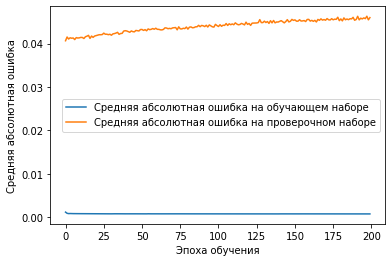

In [ ]:
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')

print(model.summary())

history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-4')

model.compile(optimizer=Adam(lr=1e-4), loss='mse')

history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=200, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-5')

model.compile(optimizer=Adam(lr=1e-5), loss='mse')

history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=200, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])


pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])
predUnscaled = yScaler.inverse_transform(pred).flatten()
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()
delta = predUnscaled - yTrainUnscaled
absDelta = abs(delta)
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta)))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()